# Parametros Globales

In [432]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

FS = 48000               # Frecuencia de muestreo
SPS = 1024                # Muestras por símbolo
Ts = 0.05           # Duración de símbolo
M = 1                    # Número de tonos => 3 bits por símbolo

# Tonos entre 4kHz y 7.5kHz
FREQS = np.array([1500, 2000])
BITS_PER_SYMBOL = 1


# Bits - ASCII

In [433]:

def text_to_bits(text):
    return [int(b) for char in text for b in format(ord(char), '08b')]

def bits_to_text(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        if len(byte) < 8:
            break
        val = int("".join(str(b) for b in byte), 2)
        chars.append(chr(val))
    return "".join(chars)

def ascii_to_bits(mensaje: str) -> np.ndarray:
    """
    Convierte una cadena ASCII en un vector de bits (0/1) de tipo int.
    1 caracter = 8 bits.
    """
    bin_str = ''.join(format(ord(c), '08b') for c in mensaje)
    bits = np.fromiter((int(b) for b in bin_str), dtype=np.int8)
    return bits

def bits_to_ascii(bits: np.ndarray) -> str:
    """
    Convierte un vector de bits (0/1) a cadena ASCII.
    La longitud de bits debe ser múltiplo de 8.
    """
    bits = bits.astype(int)
    bin_str = ''.join(str(b) for b in bits)
    chars = [chr(int(bin_str[i:i+8], 2)) for i in range(0, len(bin_str), 8)]
    return ''.join(chars)

def pad_bits_to_symbol_multiple(bits: np.ndarray, bits_per_symbol: int = 3):
    """
    Rellena con ceros al final para que la longitud de bits sea múltiplo
    de bits_per_symbol (3 para 8-PSK).
    Devuelve bits_padded, pad_bits (cuántos ceros se agregaron).
    """
    n = len(bits)
    r = n % bits_per_symbol
    if r == 0:
        return bits, 0
    pad = bits_per_symbol - r
    bits_padded = np.concatenate([bits, np.zeros(pad, dtype=np.int8)])
    return bits_padded, pad

def bits_to_symbol(bits3):
    """Convierte 3 bits a un valor entero 0–7"""
    return bits3[0]*4 + bits3[1]*2 + bits3[2]

def symbol_to_bits(sym):
    """Convierte entero 0–7 a 3 bits"""
    return [(sym >> 2) & 1, (sym >> 1) & 1, sym & 1]


# Generar simbolo FSK

In [434]:
def generate_fsk_symbol(sym):
    f = FREQS[sym]
    t = np.arange(SPS) / FS
    return np.sin(2*np.pi*f*t)
def bits_to_symbols_bfsk(bitarray):
    """
    Para BFSK: cada bit es un símbolo (0 ó 1).
    """
    return [int(b) for b in bitarray]

def symbols_to_bits_bfsk(symbols):
    """
    Para BFSK: cada símbolo (0 ó 1) es un bit.
    """
    return [int(s) for s in symbols]



# Convertir secuencia de bits a señal fsk

In [435]:
def bits_to_fsk_signal_bfsk(bitarray):
    symbols = bits_to_symbols_bfsk(bitarray)

    signal = []
    for sym in symbols:
        signal.extend(generate_fsk_symbol(sym))

    return np.array(signal, dtype=np.float32), symbols

def bits_to_fsk_signal(bitarray):
    # Asegurar longitud múltiplo de 3
    if len(bitarray) % 3 != 0:
        padding = 3 - (len(bitarray) % 3)
        bitarray = bitarray + [0]*padding

    symbols = []
    for i in range(0, len(bitarray), 3):
        bits3 = bitarray[i:i+3]
        sym = bits_to_symbol(bits3)
        symbols.append(sym)

    # construir señal
    signal = []
    for sym in symbols:
        signal.extend(generate_fsk_symbol(sym))

    return np.array(signal), symbols


# Receptor

# Detectar inicio

In [436]:
import numpy as np

def detectar_inicio_burst(rx, sps, margen_símbolos=2):
    """
    Encuentra el primer punto donde la energía sube claramente
    y devuelve la señal recortada y alineada a múltiplos de SPS.
    """
    # Energía por muestra
    power = rx**2

    # Suavizado sobre una ventana de longitud SPS
    ventana = np.ones(sps) / sps
    power_smooth = np.convolve(power, ventana, mode='same')

    # Umbral: fracción del máximo
    thresh = 0.2 * np.max(power_smooth)   # puedes ajustar 0.2 → 0.1 o 0.3

    # Primer índice donde se supera el umbral
    indices = np.where(power_smooth > thresh)[0]
    if len(indices) == 0:
        # No encontró nada, devolver rx como está
        return rx, 0

    idx_inicio = indices[0]

    # Retroceder un margen de símbolos para asegurarnos de capturar el primer símbolo completo
    inicio = max(0, idx_inicio - margen_símbolos * sps)

    # Recortar y alinear longitud a múltiplo de SPS
    longitud_simbolos = (len(rx) - inicio) // sps   # número entero de símbolos
    fin = inicio + longitud_simbolos * sps

    rx_align = rx[inicio:fin]
    return rx_align, inicio


In [437]:
def detect_symbol_from_fft(window):
    w = window * np.hanning(len(window))

    spectrum = np.fft.rfft(w)
    freqs = np.fft.rfftfreq(len(w), 1/FS)

    energies = []
    for f in FREQS:
        idx_c = np.argmin(np.abs(freqs - f))
        i0 = max(0, idx_c - 1)
        i1 = min(len(spectrum) - 1, idx_c + 1)
        e = np.sum(np.abs(spectrum[i0:i1+1])**2)
        energies.append(e)

    return int(np.argmax(energies))  # 0 ó 1



# Demodular señal

In [438]:
def fsk_signal_to_symbols_bfsk(x):
    symbols = []
    num_syms = len(x) // SPS
    for i in range(num_syms):
        w = x[i*SPS:(i+1)*SPS]
        sym = detect_symbol_from_fft(w)  # 0 ó 1
        symbols.append(sym)
    return symbols



# Contruccion de fram simple

In [439]:
def build_frame(text):
    bits = text_to_bits(text)
    signal, symbols = bits_to_fsk_signal(bits)
    return signal, symbols, bits


# FIltro pasa banda

In [440]:
# Filtrado pasa-panda
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
def aplicar_filtro_pasabanda(rx):
    lowcut = 3500.0
    highcut = 8000.0
    return bandpass_filter(rx, lowcut, highcut, FS, order=6)


# Transmitir audio

In [441]:
def play_signal(sig, fs=FS):
    sig = sig.astype(np.float32) * 0.6
    sd.play(sig, samplerate=fs)
    sd.wait()
from IPython.display import Audio, display

def display_signal(sig, fs=FS):
    sig = sig.astype(np.float32)
    display(Audio(sig, rate=fs))


# Grabar audio

In [442]:
def record_audio(duration, fs=FS):
    print(f"🎤 Grabando {duration}s…")
    rec = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("✔ Grabación finalizada.")
    return rec[:, 0]



# Prueba

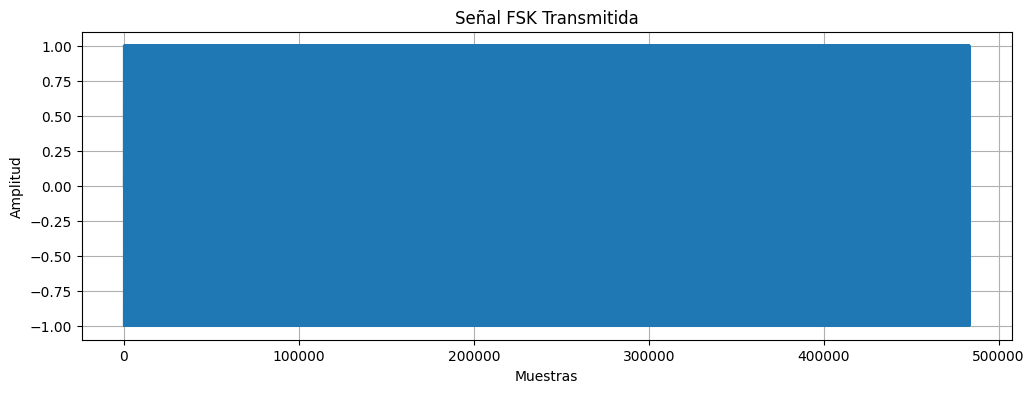

In [ ]:
# ===== TRANSMISOR =====
texto_tx = "Hola, este es un mensaje de prueba para la transmisión FSK."
preamble = 1b
bits_original = text_to_bits(texto_tx)
bits_original = text_to_bits(preamble) + bits_original
tx_signal, tx_symbols = bits_to_fsk_signal_bfsk(bits_original)

display_signal(tx_signal)  # opcional
# play_signal(tx_signal)   # cuando lo quieras mandar

# Graficar la señal transmitida
plt.figure(figsize=(12, 4))
plt.plot(tx_signal)
plt.title("Señal FSK Transmitida")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


In [444]:
# ===== RECEPTOR =====
rx = record_audio(15)

# filtrar si quieres reutilizar bandpass 4–8 kHz
rx_filt = aplicar_filtro_pasabanda(rx)

rx_aligned, idx_start = detectar_inicio_burst(rx_filt, SPS, margen_símbolos=2)

symbols_rx = fsk_signal_to_symbols_bfsk(rx_aligned)
bits_rx = symbols_to_bits_bfsk(symbols_rx)
bits_rx = bits_rx[:len(bits_original)]

texto_rx = bits_to_text(bits_rx)

errores = sum(b1 != b2 for b1, b2 in zip(bits_rx, bits_original))
print("Texto TX:", texto_tx)
print("Texto RX:", texto_rx)
print(f"Errores de bits: {errores} / {len(bits_original)}")


🎤 Grabando 15s…
✔ Grabación finalizada.
Texto TX: Hola, este es un mensaje de prueba para la transmisión FSK.
Texto RX: ÿûÿÿÿÿÿùÿÿÿÿûÿÿûÿÿûÿÿÿÿÿÿÿûÿÿûÿÿÿÿÿÿãÿÿÿÿÿÿÿÑûÝÏûÿÿÿßïÿÿãÿÿ
Errores de bits: 266 / 472
